Partie 2 : Feature Engineering
================================

Objectifs
---------
- Créer des features utilisateurs pertinentes
- Créer des features produits
- Créer des features d'interactions
- Normaliser et encoder les données


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


Chargement des Données
----------------------

Chargez les données que vous avez explorées dans le notebook précédent.


In [2]:
# Charger users.csv
users_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/users.csv")

# Charger products.csv
products_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/products.csv")

# Charger interactions.csv
interactions_df = pd.read_csv("/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/interactions.csv")


In [3]:
# TODO : Charger les données
# DATA_PATH = "../data/"

# users_df = pd.read_csv(DATA_PATH + 'users.csv')
# products_df = pd.read_csv(DATA_PATH + 'products.csv')
# interactions_df = pd.read_csv(DATA_PATH + 'interactions.csv')

# Conversion des dates
users_df['registration_date'] = pd.to_datetime(users_df['registration_date'])
products_df['added_date'] = pd.to_datetime(products_df['added_date'])
interactions_df['interaction_date'] = pd.to_datetime(interactions_df['interaction_date'])

print("Données chargées avec succès")


Données chargées avec succès


2.1 - Features Utilisateurs
----------------------------

Créez les features suivantes pour chaque utilisateur :
- Niveau d'activité (nombre d'interactions)
- Panier moyen
- Catégorie préférée
- Ancienneté de la dernière activité


In [5]:
# TODO : Créer les features utilisateurs

# 1. Niveau d'activité
user_activity = # VOTRE CODE ICI

# 2. Panier moyen
user_avg_price = # VOTRE CODE ICI

# 3. Catégorie préférée
user_favorite_category = # VOTRE CODE ICI

# 4. Ancienneté dernière activité
user_days_since_last = # VOTRE CODE ICI

# Fusion des features
users_features = users_df.copy()
# VOTRE CODE ICI pour merger toutes les features

print(f"Features utilisateurs créées : {users_features.shape}")
users_features.head()


SyntaxError: invalid syntax (1165846166.py, line 4)

Panier moyens

In [6]:
# --- Étape 1 : Créer un "dictionnaire" de prix ---
# On crée une Série Pandas où l'index est le 'product_id' et la valeur est le 'price'
# C'est comme un VLOOKUP (RECHERCHEV) ou un dictionnaire Python.
product_price_map = products_df.set_index('product_id')['price']

In [7]:
# --- Étape 2 : Filtrer les achats et appliquer les prix via .map() ---
# 1. On filtre les interactions 'purchase'
# 2. On crée la colonne 'price' en "mappant" le 'product_id' de chaque achat
#    à son prix correspondant dans notre 'product_price_map'
achats_df = interactions_df[interactions_df['interaction_type'] == 'purchase'].copy()
achats_df['price'] = achats_df['product_id'].map(product_price_map)

In [8]:
# --- Étape 3 : Grouper et Agréger (identique à avant) ---
# Ça ne change pas : on groupe par utilisateur et on calcule la somme/le compte
stats_achats_user = achats_df.groupby('user_id').agg(
    total_depense=('price', 'sum'),
    nombre_achats=('interaction_id', 'count')
)

In [9]:
# Fusionne les stats dans users_df (en gardant tous les utilisateurs)
users_df = pd.merge(
    users_df,
    stats_achats_user,
    on='user_id',
    how='left'
)

In [10]:
# Remplir les NaN (non-acheteurs) par 0 POUR LES DEUX COLONNES
users_df[['total_depense', 'nombre_achats']] = users_df[['total_depense', 'nombre_achats']].fillna(0)

In [11]:
# Convertir 'nombre_achats' en entier (plus propre)
users_df['nombre_achats'] = users_df['nombre_achats'].astype(int)

In [12]:
# --- Étape 5 : Calculer le Panier Moyen (identique à avant) ---
# Évite la division par zéro
users_df['panier_moyen'] = np.where(
    users_df['nombre_achats'] > 0,
    users_df['total_depense'] / users_df['nombre_achats'],
    0
)

In [13]:
# Arrondir (optionnel)
users_df['panier_moyen'] = users_df['panier_moyen'].round(2)

print("\n--- ✅ users_df final (méthode .map()) ---")
print(users_df.head())


--- ✅ users_df final (méthode .map()) ---
   user_id  age gender  location          registration_date  activity_level  \
0        1   33      M        69 2025-08-20 11:38:52.951867               2   
1        2   28      M        75 2024-02-27 11:38:52.951867               2   
2        3   35      M        67 2023-11-30 11:38:52.951867               2   
3        4   42      M        31 2024-08-12 11:38:52.951867               2   
4        5   28      M        69 2024-07-12 11:38:52.951867               1   

   total_depense  nombre_achats  panier_moyen  
0           0.00              0          0.00  
1         174.32              1        174.32  
2           0.00              0          0.00  
3        1565.46              2        782.73  
4           0.00              0          0.00  


Catégorie préférée

In [14]:
# Fusionne interactions et produits pour avoir la catégorie de chaque interaction
interactions_avec_categories = pd.merge(
    interactions_df[['user_id', 'product_id']],
    products_df[['product_id', 'category']],
    on='product_id',
    how='left'
)


In [15]:
# Compte le nombre de lignes pour chaque paire (utilisateur, catégorie)
comptes_categories = interactions_avec_categories.groupby(
    ['user_id', 'category']
).size().reset_index(name='compte')

In [16]:
# Trouve l'index (la ligne) où le 'compte' est maximum (.idxmax()) pour chaque 'user_id'
idx_max = comptes_categories.groupby('user_id')['compte'].idxmax()

# Sélectionne seulement ces lignes "gagnantes"
top_categories = comptes_categories.loc[idx_max]

# Renomme la colonne pour la fusion
top_categories = top_categories.rename(columns={'category': 'categorie_preferee'})

In [17]:
# Fusionne le résultat dans la table des utilisateurs
users_df = pd.merge(
    users_df,
    top_categories[['user_id', 'categorie_preferee']], # On ne prend que les colonnes utiles
    on='user_id',
    how='left' # On garde tous les utilisateurs, même s'ils n'ont pas d'interactions
)

# Remplace les 'NaN' (utilisateurs sans interactions) par 'Inconnue'
users_df['categorie_preferee'] = users_df['categorie_preferee'].fillna('Inconnue')

2.2 - Features Produits
------------------------

Créez les features suivantes pour chaque produit :
- Popularité (nombre d'interactions)
- Taux de conversion (achats/vues)
- Note moyenne
- Gamme de prix (low/mid/high)


In [ ]:
products_df

In [ ]:
# TODO : Créer les features produits

# 1. Popularité
product_popularity = # VOTRE CODE ICI

# 2. Taux de conversion
product_conversion = # VOTRE CODE ICI

# 3. Note moyenne
product_avg_rating = # VOTRE CODE ICI

# 4. Gamme de prix
def categorize_price(price):
    # VOTRE CODE ICI
    pass

# Fusion des features
products_features = products_df.copy()
# VOTRE CODE ICI

print(f"Features produits créées : {products_features.shape}")
products_features.head()


Popularité

In [ ]:

# 1. On filtre 'interactions_df' pour ne garder que les 'purchase'
# 2. On sélectionne la colonne 'product_id'
# 3. On utilise .value_counts() qui compte les occurrences de chaque 'product_id'
comptes_achats_produit = interactions_df[
    interactions_df['interaction_type'] == 'purchase'
]['product_id'].value_counts()

# .value_counts() renvoie une "Série" Pandas. Convertissons-la en DataFrame
comptes_achats_df = comptes_achats_produit.reset_index()
# Renommons les colonnes pour que ce soit clair
# 'index' (l'ancien nom) devient 'product_id', et 'product_id' (l'ancien nom) devient le compte
comptes_achats_df.columns = ['product_id', 'product_popularity']
# On utilise un 'merge' à gauche ('how='left'') pour s'assurer
# que TOUS les produits de 'products_df' sont conservés
products_df = pd.merge(
    products_df,
    comptes_achats_df,
    on='product_id',
    how='left'
)
# On les remplace logiquement par 0
products_df['product_popularity'] = products_df['product_popularity'].fillna(0)
# Optionnel mais propre : convertir la colonne en entier (integer)
products_df['product_popularity'] = products_df['product_popularity'].astype(int)




--- Étape 1 : Comptes des achats par produit ---
   product_id  product_popularity
0         654                  12
1         633                  11
2         729                  11
3         874                  10
4         589                  10


KeyError: 'product_popularity'

Taux de conversion produit

In [ ]:

# 1. On filtre les interactions pour ne garder que 'view' et 'purchase'
interactions_utiles = interactions_df[
    interactions_df['interaction_type'].isin(['view', 'purchase'])
]
# 2. On crée un tableau croisé
#    Index = les produits
#    Colonnes = les types d'interaction ('view', 'purchase')
#    Valeurs = le compte (obtenu avec aggfunc='size')
#    fill_value=0 : TRES IMPORTANT, met 0 si un produit n'a que des vues (pas d'achat) ou vice-versa
conversion_stats = interactions_utiles.pivot_table(
    index='product_id',
    columns='interaction_type',
    aggfunc='size',
    fill_value=0
).reset_index()
# Renommer les colonnes pour que ce soit propre (optionnel mais recommandé)
conversion_stats.columns.name = None
# Assurons-nous que les colonnes 'view' et 'purchase' existent, au cas où aucune n'aurait eu lieu
if 'view' not in conversion_stats.columns:
    conversion_stats['view'] = 0
if 'purchase' not in conversion_stats.columns:
    conversion_stats['purchase'] = 0
# On utilise np.where pour éviter une erreur de "division par zéro"
# SI 'view' > 0, ALORS on calcule (purchase / view), SINON on met 0
conversion_stats['product_conversion'] = np.where(
    conversion_stats['view'] > 0,
    conversion_stats['purchase'] / conversion_stats['view'],
    0
)
# On ne garde que les colonnes dont on a besoin
stats_a_fusionner = conversion_stats[['product_id', 'product_conversion']]
# On fusionne avec notre table de produits principale
products_df = pd.merge(
    products_df,
    stats_a_fusionner,
    on='product_id',
    how='left'
)
# Si un produit n'a eu NI vue NI achat, il aura 'NaN'. On le remplace par 0.
products_df['product_conversion'] = products_df['product_conversion'].fillna(0)
# Multipliez par 100 et arrondissez à 2 décimales
products_df['product_conversion'] = (products_df['product_conversion'] * 100).round(2)

--- Étape 1 : Tableau des Vues et Achats ---
   product_id  purchase  view
0           1         4    43
1           2         5    31
2           3         3    31
3           4         2    33
4           5         5    36

--- Étape 2 : Taux de conversion calculé ---
   product_id  purchase  view  product_conversion
0           1         4    43            0.093023
1           2         5    31            0.161290
2           3         3    31            0.096774
3           4         2    33            0.060606
4           5         5    36            0.138889

--- ✅ ÉTAPE FINALE : products_df avec taux de conversion (en %) ---
   product_id                                name     category  \
0           1  Dell Photo Appareil Photo Standard        Photo   
1           2      Xiaomi Ordinateurs Laptop Plus  Ordinateurs   
2           3        Sony Ordinateurs Desktop Pro  Ordinateurs   
3           4        Lenovo Accessoires Cable Pro  Accessoires   
4           5         Asus Sma

Gamme de Prix

In [21]:
# --- Étape 1 : Définir les étiquettes (labels) ---
# Ce sont les noms que nous voulons donner à nos 3 catégories
price_labels = ['low', 'mid', 'high']

# --- Étape 2 : Utiliser pd.cut pour créer la nouvelle colonne ---

# pd.cut va automatiquement :
# 1. Regarder la colonne products_df['price']
# 2. Définir 3 intervalles de prix de taille égale (grâce à bins=3)
# 3. Assigner un label de 'price_labels' à chaque produit
# 4. 'include_lowest=True' garantit que votre prix min (10.69) est bien inclus
products_df['categorize_price'] = pd.cut(
    products_df['price'],
    bins=3,
    labels=price_labels,
    include_lowest=True
)

print("\n--- ✅ ÉTAPE FINALE : products_df avec catégorie de prix ---")
print(products_df[['product_id', 'name', 'price', 'categorize_price']].head())


# --- Bonus : Vérifier la répartition ---
# Ceci vous montre combien de produits sont dans chaque bac
print("\n--- Répartition des catégories de prix ---")
print(products_df['categorize_price'].value_counts())


--- ✅ ÉTAPE FINALE : products_df avec catégorie de prix ---
   product_id                                name    price categorize_price
0           1  Dell Photo Appareil Photo Standard  4526.99             high
1           2      Xiaomi Ordinateurs Laptop Plus   895.93              low
2           3        Sony Ordinateurs Desktop Pro  2786.19              mid
3           4        Lenovo Accessoires Cable Pro   176.90              low
4           5         Asus Smartphones iPhone Pro   690.03              low

--- Répartition des catégories de prix ---
categorize_price
low     809
mid     154
high     37
Name: count, dtype: int64


# Supressions des doublons 

In [ ]:
interactions_cleaned = interactions_df.drop_duplicates()

users_cleaned = users_df.drop_duplicates()

products_cleaned = products_df.drop_duplicates()

# visualisation

2.3 - Normalisation et Encodage
---------------------------------

Normalisez les features numériques et encodez les features catégorielles.


In [ ]:
# TODO : Normalisation et encodage

# Normalisation des features numériques
scaler = StandardScaler()
# VOTRE CODE ICI

# Encodage des features catégorielles
label_encoders = {}
# VOTRE CODE ICI

print("Normalisation et encodage terminés")


In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- 1. COPIE DES DATAFRAMES ---
# On crée des copies pour ne pas modifier les originaux,
# qui sont utiles pour les approches 1 et 2.
products_processed_df = products_df.copy()
users_processed_df = users_df.copy()
interactions_processed_df = interactions_df.copy()

# --- 2. Normalisation des features numériques ---
print("Début de la normalisation...")
scaler = StandardScaler()

# 2a. products_df
product_num_features = ['price', 'stock', 'initial_rating', 'product_popularity_y', 'product_conversion']
products_processed_df[product_num_features] = scaler.fit_transform(
    products_processed_df[product_num_features] # <--- On passe le DataFrame
)

# 2b. users_df
user_num_features = ['age', 'activity_level', 'total_depense', 'nombre_achats', 'panier_moyen']
users_processed_df[user_num_features] = scaler.fit_transform(
    users_processed_df[user_num_features]
)

# 2c. interactions_df (avec gestion des NaN)
interaction_num_features = ['rating', 'session_duration']
# GESTION DES NaN : Le scaler ne fonctionne pas sur des 'NaN'. On remplace par 0.
interactions_processed_df[interaction_num_features] = \
    interactions_processed_df[interaction_num_features].fillna(0)
    
interactions_processed_df[interaction_num_features] = scaler.fit_transform(
    interactions_processed_df[interaction_num_features]
)

print("Normalisation terminée.")

# --- 3. Encodage des features catégorielles ---
print("Début de l'encodage...")
label_encoders = {} # Dictionnaire pour stocker les encodeurs

# 3a. products_df
product_cat_features = ['category', 'subcategory', 'categorize_price']
for col in product_cat_features:
    le = LabelEncoder()
    products_processed_df[col] = le.fit_transform(products_processed_df[col])
    label_encoders[f'product_{col}'] = le # Sauvegarde de l'encodeur

# 3b. users_df
user_cat_features = ['gender', 'location', 'categorie_preferee']
for col in user_cat_features:
    le = LabelEncoder()
    users_processed_df[col] = le.fit_transform(users_processed_df[col])
    label_encoders[f'user_{col}'] = le

# 3c. interactions_df
interaction_cat_features = ['interaction_type']
for col in interaction_cat_features:
    le = LabelEncoder()
    interactions_processed_df[col] = le.fit_transform(interactions_processed_df[col])
    label_encoders[f'interaction_{col}'] = le

print("Encodage terminé.")

Début de la normalisation...
Normalisation terminée.
Début de l'encodage...
Encodage terminé.


In [ ]:
interactions_processed_df

2.4 - Analyse de Corrélation
-----------------------------

Analysez les corrélations entre les différentes features.


In [ ]:
# TODO : Matrice de corrélation

# Créer une matrice de corrélation
# VOTRE CODE ICI

# Visualiser avec une heatmap
plt.figure(figsize=(12, 10))
# VOTRE CODE ICI
plt.show()


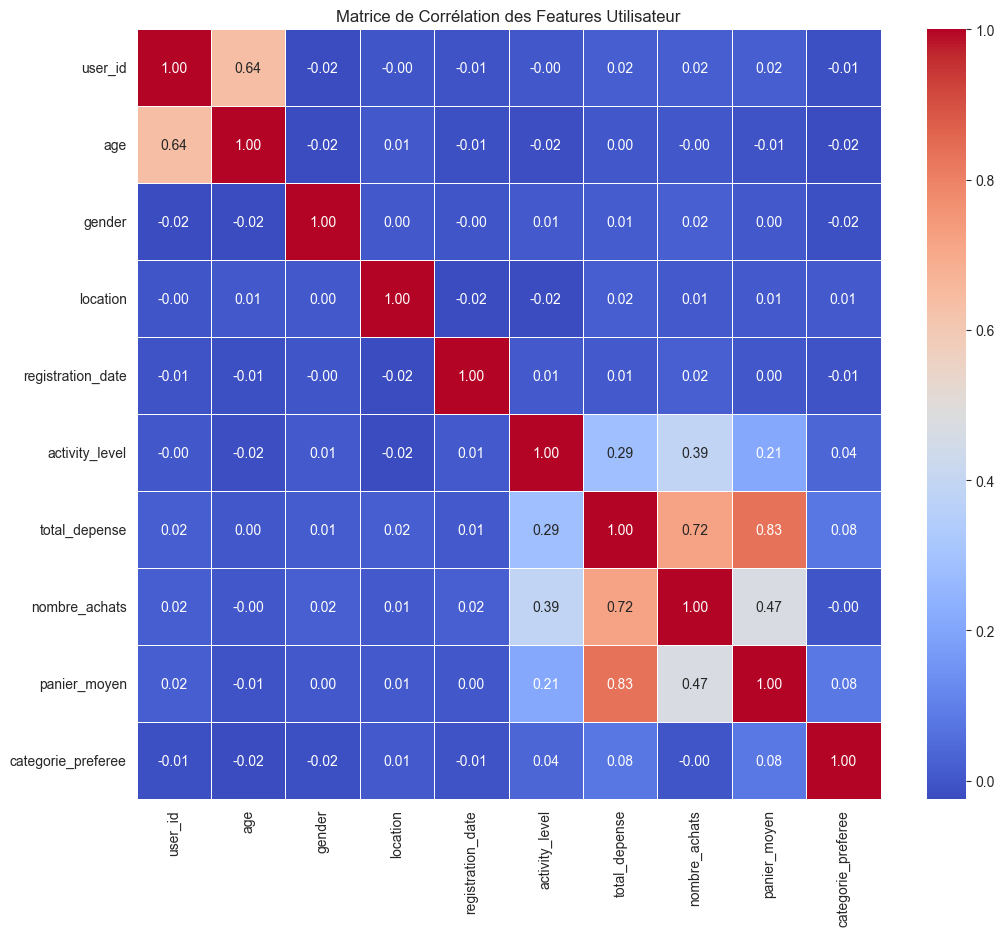

In [31]:
# TODO : Matrice de corrélation

# users_processed_df est un bon choix pour voir les liens entre âge, activité, etc.
correlation_matrix = users_processed_df.corr()

# Visualiser avec une heatmap
plt.figure(figsize=(12, 10))
# On utilise sns.heatmap pour la visualisation
sns.heatmap(
    correlation_matrix, 
    annot=True,      
    cmap='coolwarm', 
    fmt='.2f',      
    linewidths=.5    
)
plt.title("Matrice de Corrélation des Features Utilisateur")
plt.show()

# Downloads

In [28]:
users_df.to_csv('/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/users.csv', index=False)

interactions_df.to_csv('/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/interactions.csv', index=False)

products_df.to_csv('/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/products.csv', index=False)

In [32]:
products_processed_df.to_csv('/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/products_processed.csv', index=False)

users_processed_df.to_csv('/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/users_processed.csv', index=False)

interactions_processed_df.to_csv('/Users/djessim.djb/Downloads/develloppement/projet/ynov/IA M1/Ecom-recommandation/Data/interactions_processed.csv', index=False)


Prochaines Étapes
-----------------

Maintenant que les features sont créées, passez au notebook 03_Modeling_starter.ipynb pour implémenter les modèles de recommandation.
